In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
import seaborn as sns

/tmp/ipykernel_5225/4090892198.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [12]:
nPerClust=200
r1=10
r2=15
th=np.linspace(0,4*np.pi,nPerClust)
a=[r1*np.cos(th)+np.random.randn(nPerClust)*3,
   r1*np.sin(th)+np.random.randn(nPerClust)]
b=[r2*np.cos(th)+np.random.randn(nPerClust),
   r2*np.sin(th)+np.random.randn(nPerClust)*3]
labels_np=np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))
data_np=np.hstack((a,b)).T
data=torch.tensor(data_np).float()
labels=torch.tensor(labels_np).float()


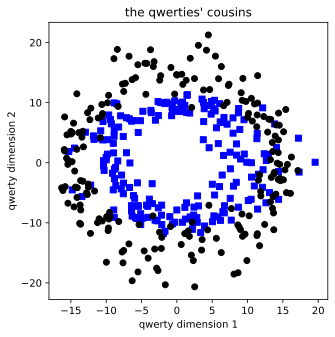

In [13]:
fig=plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1],'ko')
plt.title("the qwerties' cousins")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
data, labels, test_size=0.2, random_state=42)
train_data=TensorDataset(X_train,y_train)
test_data=TensorDataset(X_test,y_test)
train_loader=DataLoader(train_data,batch_size=16,shuffle=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [19]:
class theModelClass(nn.Module):
    def __init__(self,dropoutRate):
        super().__init__()
        self.input=nn.Linear(2,128)
        self.hidden=nn.Linear(128,128)
        self.output=nn.Linear(128,1)
        self.dr=dropoutRate
        
    def forward(self,x):
        x=F.relu(self.input(x))
        x=F.dropout(x,p=self.dr,training=self.training)
        x=F.relu(self.hidden(x))
        x=F.dropout(x,p=self.dr,training=self.training)
        x=self.output(x)
        return x
        

In [20]:
tmpnet=theModelClass(0.25)
tmpdata=torch.randn((10,2))
yHat=tmpnet(tmpdata)
yHat

tensor([[-0.0200],
        [-0.0079],
        [-0.3056],
        [-0.0435],
        [-0.1095],
        [-0.0098],
        [-0.0050],
        [-0.1043],
        [-0.0541],
        [-0.1547]], grad_fn=<AddmmBackward0>)

In [21]:
def createANN(dropoutrate):
    ANNQC=theModelClass(dropoutrate)
    lossfun=nn.BCEWithLogitsLoss()
    optimizer=torch.optim.SGD(ANNQC.parameters(),lr=0.002)
    return ANNQC,lossfun,optimizer


In [23]:
numepoches=1000
def trainTheModel(ANNQC,lossfun,optimizer):
    trainAcc=[]
    testAcc=[]
    
    for epochi in range(numepoches):
        ANNQC.train()
        batchAcc=[]
        for X,y in train_loader:
            yHat=ANNQC(X)
            loss=lossfun(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchAcc.append(100*torch.mean(((yHat>0.5)==y).float()).item())
            
        trainAcc.append(np.mean(batchAcc))
        
        ANNQC.eval()
        X,y=next(iter(test_loader))
        yHat=ANNQC(X)
        testAcc.append(100*torch.mean(((yHat>0.5)==y).float()).item())
    return trainAcc,testAcc    

In [24]:
dropoutrate=0
ANNQC,lossfun,optimizer=createANN(dropoutrate)
rainAcc,testAcc=trainTheModel(ANNQC,lossfun,optimizer)

In [34]:
def smooth(x,k=5):
       return np.convolve(x,np.ones(k)/k,mode='same')

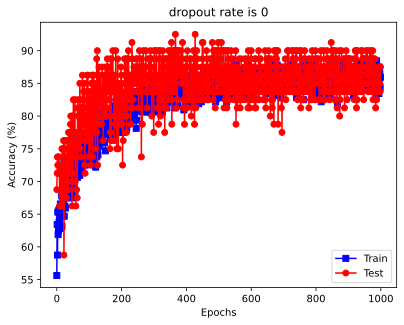

In [26]:
plt.plot(rainAcc,'bs-')
plt.plot(testAcc,'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title(f'dropout rate is {dropoutrate}')
plt.show()

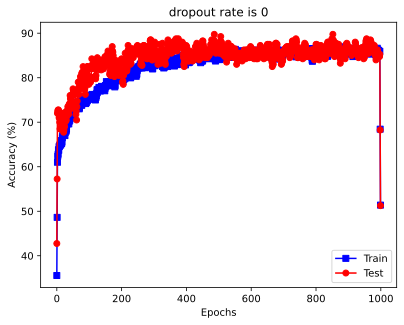

In [35]:
plt.plot(smooth(rainAcc),'bs-')
plt.plot(smooth(testAcc),'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title(f'dropout rate is {dropoutrate}')
plt.show()

In [36]:
dropoutRates=np.arange(10)/10
results=np.zeros((len(dropoutRates),2))
for di in range(len(dropoutRates)):
    
    ANNQC,lossfun,optimizer=createANN(dropoutRates[di])
    trainAcc,testAcc=trainTheModel(ANNQC,lossfun,optimizer)
    results[di,0]=np.mean(trainAcc[-100:])
    results[di,1]=np.mean(testAcc[-100:])
    

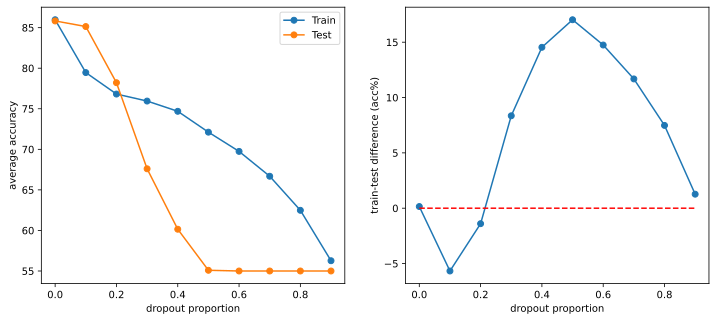

In [39]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('dropout proportion')
ax[0].set_ylabel('average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,0.9],[0,0],'r--')
ax[1].set_xlabel('dropout proportion')
ax[1].set_ylabel('train-test difference (acc%)')

plt.show()


In [41]:
iris=sns.load_dataset('iris')
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [81]:
data=iris.drop(columns=['species']).values
data=torch.tensor(data).float()
iris.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [82]:
labels=torch.zeros(len(X),dtype=torch.long)
labels[iris.species=='versicolor']=1
labels[iris.species=='virginica']=2


In [83]:
X_train, X_test, y_train, y_test = train_test_split(
data, labels, test_size=0.2, random_state=42)
train_data=TensorDataset(X_train,y_train)
test_data=TensorDataset(X_test,y_test)
train_loader=DataLoader(train_data,batch_size=16,shuffle=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [84]:
class theModelClass(nn.Module):
    def __init__(self,dropoutRate):
        super().__init__()
        self.input=nn.Linear(4,12)
        self.hidden=nn.Linear(12,12)
        self.output=nn.Linear(12,3)
        self.dr=dropoutRate
        
    def forward(self,x):
        x=F.relu(self.input(x))
        x=F.dropout(x,p=self.dr,training=self.training)
        x=F.relu(self.hidden(x))
        x=F.dropout(x,p=self.dr,training=self.training)
        x=self.output(x)
        return x
        

In [85]:
def createANN(dropoutrate):
    ANNiris=theModelClass(dropoutrate)
    lossfun=nn.CrossEntropyLoss()
    optimizer=torch.optim.SGD(ANNiris.parameters(),lr=0.002)
    return ANNiris,lossfun,optimizer


In [86]:
numepoches=500
def trainTheModel(ANNiris,lossfun,optimizer):
    trainAcc=[]
    testAcc=[]
    
    for epochi in range(numepoches):
        ANNiris.train()
        batchAcc=[]
        for X,y in train_loader:
            yHat=ANNiris(X)
            loss=lossfun(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
            
        trainAcc.append(np.mean(batchAcc))
        
        ANNiris.eval()
        X,y=next(iter(test_loader))
        predlabels=torch.argmax(ANNiris(X),axis=1)
        testAcc.append(100*torch.mean((predlabels==y).float()).item())
    return trainAcc,testAcc    

In [87]:
dropoutrate=0.5
ANNiris,lossfun,optimizer=createANN(dropoutrate)
trainAcc,testAcc=trainTheModel(ANNiris,lossfun,optimizer)

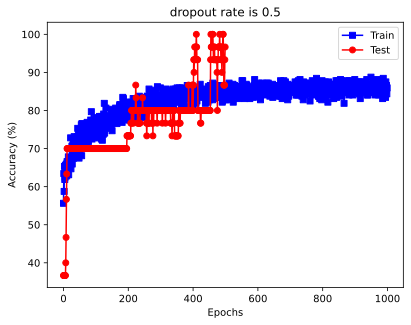

In [88]:
plt.plot(rainAcc,'bs-')
plt.plot(testAcc,'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title(f'dropout rate is {dropoutrate}')
plt.show()

In [91]:
dropoutrate=0
ANNiris,lossfun,optimizer=createANN(dropoutrate)
trainAcc,testAcc=trainTheModel(ANNiris,lossfun,optimizer)

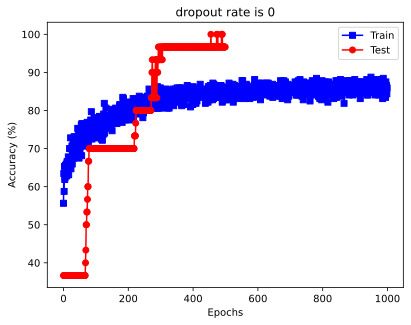

In [92]:
plt.plot(rainAcc,'bs-')
plt.plot(testAcc,'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title(f'dropout rate is {dropoutrate}')
plt.show()

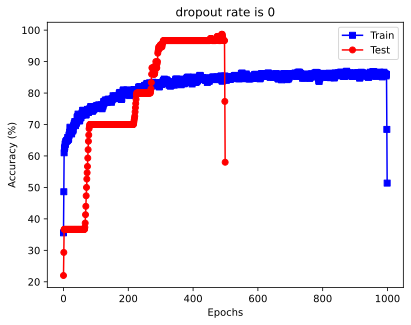

In [93]:
plt.plot(smooth(rainAcc),'bs-')
plt.plot(smooth(testAcc),'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title(f'dropout rate is {dropoutrate}')
plt.show()

In [95]:
dropoutRates=np.arange(10)/10
results=np.zeros((len(dropoutRates),2))
for di in range(len(dropoutRates)):
    
    ANNiris,lossfun,optimizer=createANN(dropoutRates[di])
    trainAcc,testAcc=trainTheModel(ANNiris,lossfun,optimizer)
    results[di,0]=np.mean(trainAcc[-100:])
    results[di,1]=np.mean(testAcc[-100:])
    

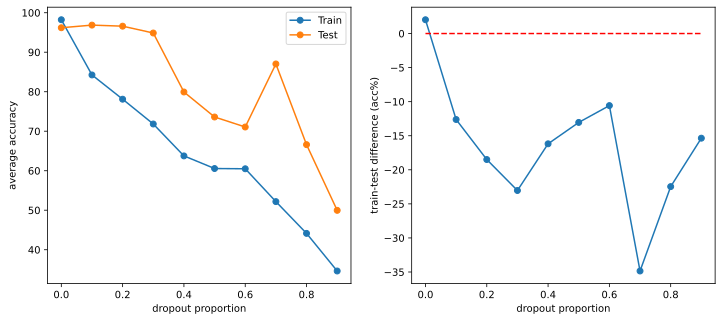

In [96]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('dropout proportion')
ax[0].set_ylabel('average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,0.9],[0,0],'r--')
ax[1].set_xlabel('dropout proportion')
ax[1].set_ylabel('train-test difference (acc%)')

plt.show()
